# Trader Sentiment Analysis

Original News Feed from http://articlefeeds.nasdaq.com/nasdaq/symbols?symbol=TSLA. This changed to https://stocknews.com/news-snippets-page/?date=&type=all&stock-category=all&symbol=tsla as detailed below. 

In [ ]:
# Library load section
import sys
!{sys.executable} -m pip install cython
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install BeautifulSoup4
!{sys.executable} -m pip install selenium

In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install -U textblob

tensorflow 1.9.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.2.0 which is incompatible.
tensorflow 1.9.0 has requirement tensorboard<1.10.0,>=1.9.0, but you'll have tensorboard 1.10.0 which is incompatible.


In [1]:
# Imports
import numpy as np
import keras
import pandas as pd
#import tensorflow as tf
import urllib.request 
import urllib.error 
#from io import StringIO
import time
import requests
# Froms
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#%matplotlib inline #The next two lines are pure python that also works in Spyder
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from lxml import etree
from io import BytesIO
from io import StringIO
from bs4 import BeautifulSoup 
from lxml import etree 
from lxml import html 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from textblob import TextBlob

Using TensorFlow backend.


# Technology Direction Change

New research has moved from using PubNub and reading html using BeautifulSoup with the NASDAQ website (http://articlefeeds.nasdaq.com/nasdaq/symbols?symbol=TSLA) to a combination of BeautifulSoup, Selenium's Webdriver, Pandas, using an example detailed in https://www.youtube.com/watch?v=Zh2fkZ-uzBU and scraping content from this site https://stocknews.com/news-snippets-page/?date=&type=all&stock-category=all&symbol=tsla. 

One problem in using the method described by Kevin Markham of the Data School is that it does not account for dynamic material. If you view the source of the stocknews web page above, you do not get the html of the table. It uses javaScript. Further research identified a means to get the html and scrape it for content using a library called Selenium, https://www.youtube.com/watch?v=O--WVte1WhU.

# Load the webpage

In [2]:
# Connect to the webpage, read the dynamic html provided by javaScript and load into a BeautifulSoup container
print('Use of Google Chrome is required for this application. It also requires the latest chromedriver.exe')
# Add function to select chromedriver.
try:
    chrome_path = r"C:\Dave\UWF\COT6931-II\Sources\chromedriver.exe" # Consider selecting this location at runtime.
except Exception as e:
    print(e, 'chromedriver.exe not found in ', chrome_path)
    #break
filename = 'AMZNstock_records.csv' # Select this name?
driver = webdriver.Chrome(chrome_path)
# try?
#driver.get("https://stocknews.com/news-snippets-page/?date=&type=all&stock-category=all&symbol=tsla")
driver.get("https://stocknews.com/stock/AMZN/news/")
time.sleep(30) #pauses for 30 seconds to manually login and to prevent IP blocking due to the quasi-legal nature of web-scraping

no_of_pagedowns = 20
while no_of_pagedowns: # Load more news
    try:
        driver.find_element_by_xpath("//*[@id='load-more-button']").send_keys(Keys.ENTER)
        time.sleep(2)
        no_of_pagedowns-=1
    except Exception as e:
        print(e)
        break
time.sleep(5)
soup = BeautifulSoup(driver.page_source, 'lxml')
#print(soup.prettify()) # HTML achieved
driver.quit()

Use of Google Chrome is required for this application. It also requires the latest chromedriver.exe
Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='load-more-button']"}
  (Session info: chrome=70.0.3538.77)
  (Driver info: chromedriver=2.42.591088 (7b2b2dca23cca0862f674758c9a3933e685c27d5),platform=Windows NT 10.0.17134 x86_64)



# Scraping all of the articles for full sentiment analysis

In [9]:
def pageScrapeOne(url):
    try:
        res = requests.get(url)
    except Exception as e:
        print("URL not found. Body text not harvested.")
        return    
    soup_body = BeautifulSoup(res.text,"lxml")
    article_text = ''
    article = soup_body.find("div", {"class":"post_content"}).findAll('p')
    for element in article:
        article_text += '\n' + ''.join(element.findAll(text = True))    
    article_text = review_to_words(article_text) # New
    res.close()
    time.sleep(5)
    return article_text   

Additional formatting to clean the news body text. This capability was discovered by reviewing Kaggle - https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words

In [ ]:
def review_to_words(review_text):
    # Function to convert a raw review to a string of words. The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    # Remove HTML
    #review_text = BeautifulSoup(raw_review).get_text() 
    
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))

# Assigns the data to an array and gets the news article's body text

In [30]:
# Locates the desired table and loads all records from the table rows to the record dataset
table = soup.find('tbody', attrs = {'id':'snippets-tbody'}) 
records = []
count = 1
for row in table.findAll('tr', attrs = {'style':''}): 
    record = {} 
    record['date'] = row.find('span', attrs = {'class':'medium-gray'}).text + ', 2018'
    record['url'] = 'https://stocknews.com' + row.find('td', attrs = {'data-title':'News Detail'}).a['href']
    record['price'] = row.find('td', attrs = {'class':'text-right'}).text 
    record['heading'] = row.find('span', attrs = {'class':'dark-gray'}).text
    record['heading_sentiment'] = inlineSA(record['heading'])
    record['body'] = pageScrapeOne('https://stocknews.com' + row.find('td', attrs = {'data-title':'News Detail'}).a['href'])
    record['body_sentiment'] = inlineSA(record['body'])
    records.append((record))
    print('Record ', count)
    count += 1
    time.sleep(3)

Record  1
Record  2
Record  3
Record  4
Record  5
Record  6
Record  7
Record  8
Record  9
Record  10
Record  11
Record  12
Record  13
Record  14
Record  15
Record  16
Record  17
Record  18
Record  19
Record  20
Record  21
Record  22
Record  23
Record  24
Record  25
Record  26
Record  27
Record  28
Record  29
Record  30
Record  31
Record  32
Record  33
Record  34
Record  35
Record  36
Record  37
Record  38
Record  39
Record  40
Record  41
Record  42
Record  43
Record  44
Record  45
Record  46
Record  47
Record  48
Record  49
Record  50
Record  51
Record  52
Record  53
Record  54
Record  55
Record  56
Record  57
Record  58
Record  59
Record  60
Record  61
Record  62
Record  63
Record  64
Record  65
Record  66
Record  67
Record  68
Record  69
Record  70
Record  71
Record  72
Record  73
Record  74
Record  75
Record  76
Record  77
Record  78
Record  79
Record  80
Record  81
Record  82
Record  83
Record  84
Record  85
Record  86
Record  87
Record  88
Record  89
Record  90
Record  91
Record  

# Using TextBlob Sentiment Analysis while setting the sentiment score

In [8]:
def inlineSA(text):
    testimonial = TextBlob(text)
    #Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857) - Sample
    sa = testimonial.sentiment.polarity # 0.39166666666666666 - sample
    if (sa >= -1 and sa <= -0.6):
        return 1
    elif (sa > -0.6 and sa <= -0.2):
        return 2
    elif (sa > 0.2 and sa <= 0.6):
        return 4
    elif (sa > 0.6 and sa <= 1.0):
        return 5
    return 3

# Pandas DataFrame to CSV

In [57]:
# Pandas DataFrame to CSV file
df = pd.DataFrame(records, columns=['date', 'heading', 'heading_sentiment', 'price', 'url', 'body', 'body_sentiment'])
df['date'] = pd.to_datetime(df['date'])
df.to_csv(filename, index=False, encoding='utf-8')

# Test Display

In [59]:
# Display csv file
#filename = 'stock_records.csv' # Select this name?
df1 = pd.read_csv(filename)
print(df1)

           date                                            heading  \
0    2018-10-25  Tesla (TSLA) 'obviously' plans to take on Uber...   
1    2018-10-25   Tesla Inc (TSLA) Shares Rise After Earnings Beat   
2    2018-10-24  Analyst Places Outperform Rating on Tesla Inc ...   
3    2018-10-23  Tesla (TSLA) stock jumps after legendary short...   
4    2018-10-20                 How did Tesla (TSLA) get its name?   
5    2018-10-19   Tesla Inc (TSLA) Introduces Lower-Priced Model 3   
6    2018-10-17  Tesla Inc's (TSLA) Elon Musk Plans to Buy Mass...   
7    2018-10-17  Tesla Inc (TSLA) Snags Plot of Land for China ...   
8    2018-10-15  Tesla, Inc (TSLA) Tries To Pump Up Sales of it...   
9    2018-10-14  Tesla, Inc (TSLA) reportedly produced 7,400 Mo...   
10   2018-10-12   Tesla, Inc (TSLA) Full Tax Credit Set to Go Away   
11   2018-10-11  Lots of Uncertainty Surrounding Next Tesla Inc...   
12   2018-10-11  Tesla CEO Elon Musk denies FT report suggestin...   
13   2018-10-10  Com

# Correlation Graph
Combining different graphs with same X-axis [Date] Example used - https://www.youtube.com/watch?v=8EsK5DQ62q4.
It became apparent the either the body text was too much for TextBlob or was not concise enough to diverge much from the 'neutral' rating. I would also consider graphing the actual output from TextBlob [-1.0 - 1.0] in place of the 1-5 rank.

In [181]:
# Reading from a file
filename = 'stock_records.csv' # Select this name?
df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])

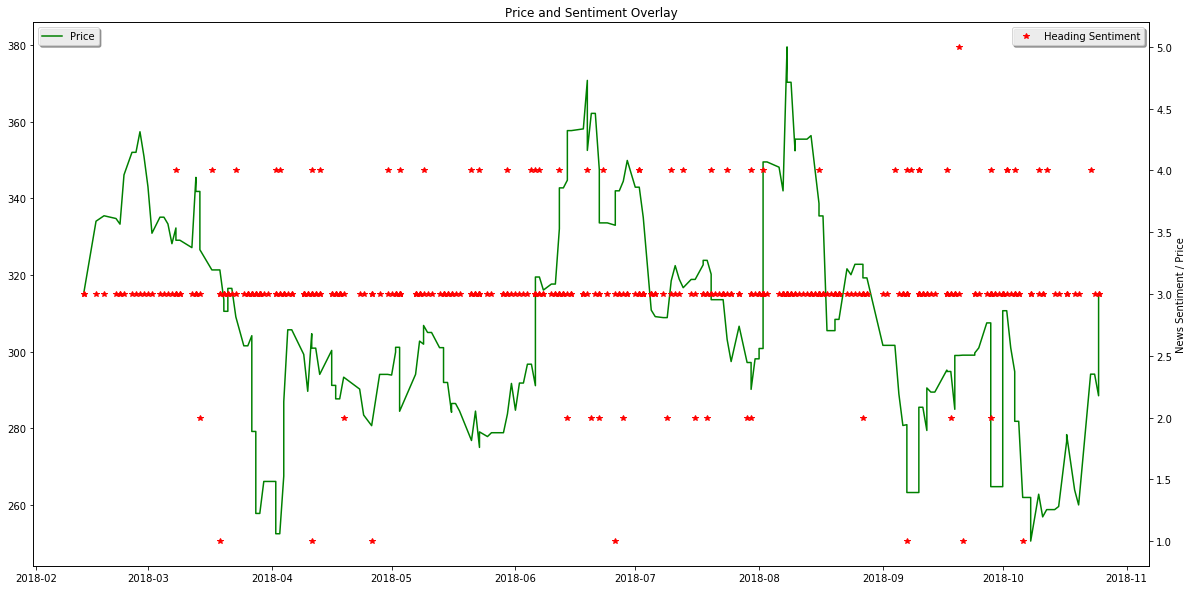

In [182]:
x = df['date']
y = df['price'].astype(float)
z1 = df['heading_sentiment']
z2 = df['body_sentiment']
# separate the figure object and axes object from the plotting object
fig, ax1 = plt.subplots(figsize=(20,10))
# duplicate the axes with a different y axis and the same x axis
ax2 = ax1.twinx() # ax2 and ax1 with have a common x axis and different y axis
# plot the curves on axes 1, and 2, and get the curve handles
plt.xticks(rotation='vertical')
curve1 = ax1.plot(x, y, label = 'Price', color = 'g')
curve2 = ax2.plot_date(x, z1, label = 'Heading Sentiment', color = 'r', marker='*')
#curve3 = ax2.plot_date(x, z2, label = 'Body Sentiment', color = 'c', marker='+')
plt.title('Price and Sentiment Overlay')
plt.xlabel('Date')
plt.ylabel('News Sentiment / Price')
ax1.legend(loc=2, shadow=True)
ax2.legend(loc=1, shadow=True)
plt.show()

# Development Test Range

Simple GUI This is now not latest. See Spyder

In [ ]:
import sys
from PyQt4 import QtGui, QtCore

try:
    _fromUtf8 = QtCore.QString.fromUtf8
except AttributeError:
    def _fromUtf8(s):
        return s

class Window(QtGui.QMainWindow):

    def __init__(self):
        super(Window, self).__init__()
        #self.setGeometry(520, 660, 341, 32)
        self.resize(570, 660)
        self.move(341, 32)
        self.setWindowTitle("TraderSA")
        self.setWindowIcon(QtGui.QIcon('TeslaLogo.png'))
        self.home()
        
    def home(self):
        # Stock symbol selection
        lblStockName = QtGui.QLabel("Stock Symbol", self)
        lblStockName.move(150, 40)
        lblStockName.resize(89, 25)
        lblStockName.setObjectName(_fromUtf8("lblStockName"))
        cmbStockSymbol = QtGui.QComboBox(self)
        cmbStockSymbol.setEnabled(True)
        cmbStockSymbol.addItem("TSLA")
        cmbStockSymbol.addItem("AMZN")
        cmbStockSymbol.move(150, 40)
        cmbStockSymbol.resize(89, 25)
        #cmbStockSymbol.activated[str].connect(self.style_choice)
        #cmbStockSymbol.setCurrentText(_fromUtf8(""))
        #cmbStockSymbol.setObjectName(_fromUtf8("cmbStockSymbol"))
        # News/price source
        lblNewsPriceSource = QtGui.QLabel("News and Price Source", self)
        lblNewsPriceSource.move(30, 90)
        lblNewsPriceSource.resize(131, 16)
        lblNewsPriceSource.setObjectName(_fromUtf8("lblNewsPriceSource"))
        cmbNewsPriceSource = QtGui.QComboBox(self)
        cmbNewsPriceSource.addItem("Stocknews.com")
        cmbNewsPriceSource.move(200, 90)
        cmbNewsPriceSource.resize(211, 16)
        #cmbNewsPriceSource.setCurrentText(_fromUtf8(""))
        #cmbNewsPriceSource.setObjectName(_fromUtf8("cmbNewsPriceSource"))
        # Generate a new Scored News/Price dataset
        btnGenerateNewsPriceFile = QtGui.QPushButton("&Generate News-Price File", self)
        btnGenerateNewsPriceFile.clicked.connect(self.close_application)
        btnGenerateNewsPriceFile.move(30, 220)
        btnGenerateNewsPriceFile.resize(141, 23)
        btnGenerateNewsPriceFile.setObjectName(_fromUtf8("btnGenerateNewsPriceFile"))
        # Select a CSV data file
        btnSelectExistingFile = QtGui.QPushButton("&Select Existing File", self)
        btnSelectExistingFile.clicked.connect(self.close_application)
        btnSelectExistingFile.move(30, 280)
        btnSelectExistingFile.resize(141, 23)
        btnSelectExistingFile.setObjectName(_fromUtf8("btnSelectExistingFile"))
        # Train the algorithm - Not used
        btnTrain = QtGui.QPushButton("&Train Algorithm", self)
        #btnTrain.clicked.connect(self.close_application)
        btnTrain.move(30, 320)
        btnTrain.resize(141, 23)
        btnTrain.setObjectName(_fromUtf8("btnTrain"))
        # Test/Correlate data
        btnTest = QtGui.QPushButton("Execute &Correlation Test", self)
        #btnTest.clicked.connect(self.close_application)
        btnTest.move(30, 360)
        btnTest.resize(141, 23)
        btnTest.setObjectName(_fromUtf8("btnTest"))
        # Testing accuracy results
        lblAccuracy = QtGui.QLabel("Training Accuracy", self)
        lblAccuracy.move(230, 320)
        lblAccuracy.resize(51, 16)
        lblAccuracy.setObjectName(_fromUtf8("lblAccuracy"))
        txtAccuracy = QtGui.QLineEdit("", self)
        txtAccuracy.move(290, 320)
        txtAccuracy.resize(101, 20)
        txtAccuracy.setObjectName(_fromUtf8("txtAccuracy"))
        # Correlation results multiline textbox
        lblTestResults = QtGui.QLabel("Correlation Results", self)
        lblTestResults.move(30, 400)
        lblTestResults.resize(111, 16)
        lblTestResults.setObjectName(_fromUtf8("lblTestResults"))
        textEdit = QtGui.QTextEdit("", self)
        textEdit.move(30, 420)
        textEdit.resize(511, 121)
        textEdit.setObjectName(_fromUtf8("textEdit"))
        # Dialog control buttons
        # Help
        btnHelp = QtGui.QPushButton("&Help", self)
        #btnHelp.clicked.connect(self.close_application)
        btnHelp.move(460, 560)
        btnHelp.resize(75, 23)
        btnHelp.setObjectName(_fromUtf8("btnHelp"))
        # Close/Exit
        btnClose = QtGui.QPushButton("&Close", self)
        btnClose.clicked.connect(self.close_application)
        btnClose.move(370, 560)
        btnClose.resize(75, 23)
        btnClose.setObjectName(_fromUtf8("btnClose"))
        # Report
        btnReport = QtGui.QPushButton("&Report", self)
        #btnReport.clicked.connect(self.close_application)
        btnReport.move(280, 560)
        btnReport.resize(75, 23)
        btnReport.setObjectName(_fromUtf8("btnReport"))
        
        self.show()
        
    def close_application(self):
        #print("So freeking custom!")
        sys.exit()
        
def run():
    app = QtGui.QApplication(sys.argv)
    GUI = Window()
    sys.exit(app.exec_())

run()

TraderMain

In [1]:
# -*- coding: utf-8 -*-

# Form implementation generated from reading ui file 'TraderMain.ui'
#
# Created by: PyQt4 UI code generator 4.11.4
#
# WARNING! All changes made in this file will be lost!

from PyQt4 import QtCore, QtGui

try:
    _fromUtf8 = QtCore.QString.fromUtf8
except AttributeError:
    def _fromUtf8(s):
        return s

try:
    _encoding = QtGui.QApplication.UnicodeUTF8
    def _translate(context, text, disambig):
        return QtGui.QApplication.translate(context, text, disambig, _encoding)
except AttributeError:
    def _translate(context, text, disambig):
        return QtGui.QApplication.translate(context, text, disambig)

class Ui_Dialog(object):
    def setupUi(self, Dialog):
        Dialog.setObjectName(_fromUtf8("Dialog"))
        self.buttonBox = QtGui.QDialogButtonBox(Dialog)
        self.buttonBox.setGeometry(QtCore.QRect(520, 660, 341, 32))
        self.buttonBox.setOrientation(QtCore.Qt.Horizontal)
        self.buttonBox.setStandardButtons(QtGui.QDialogButtonBox.Cancel|QtGui.QDialogButtonBox.Ok)
        self.buttonBox.setObjectName(_fromUtf8("buttonBox"))
        self.lblStockName = QtGui.QLabel(Dialog)
        self.lblStockName.setGeometry(QtCore.QRect(30, 40, 89, 25))
        self.lblStockName.setObjectName(_fromUtf8("lblStockName"))
        self.cmbStockSymbol = QtGui.QComboBox(Dialog)
        self.cmbStockSymbol.setEnabled(True)
        self.cmbStockSymbol.setGeometry(QtCore.QRect(200, 40, 60, 22))
        self.cmbStockSymbol.setCurrentText(_fromUtf8(""))
        self.cmbStockSymbol.setObjectName(_fromUtf8("cmbStockSymbol"))
        self.lblNewsPriceSource = QtGui.QLabel(Dialog)
        self.lblNewsPriceSource.setGeometry(QtCore.QRect(30, 90, 131, 16))
        self.lblNewsPriceSource.setObjectName(_fromUtf8("lblNewsPriceSource"))
        self.cmbNewsPriceSource = QtGui.QComboBox(Dialog)
        self.cmbNewsPriceSource.setGeometry(QtCore.QRect(200, 90, 211, 22))
        self.cmbNewsPriceSource.setCurrentText(_fromUtf8(""))
        self.cmbNewsPriceSource.setObjectName(_fromUtf8("cmbNewsPriceSource"))
        self.lblDateRange = QtGui.QLabel(Dialog)
        self.lblDateRange.setGeometry(QtCore.QRect(30, 140, 91, 16))
        self.lblDateRange.setObjectName(_fromUtf8("lblDateRange"))
        self.dateFrom = QtGui.QDateEdit(Dialog)
        self.dateFrom.setGeometry(QtCore.QRect(30, 180, 110, 22))
        self.dateFrom.setObjectName(_fromUtf8("dateFrom"))
        self.lblTo = QtGui.QLabel(Dialog)
        self.lblTo.setGeometry(QtCore.QRect(180, 180, 21, 16))
        self.lblTo.setObjectName(_fromUtf8("lblTo"))
        self.dateTo = QtGui.QDateEdit(Dialog)
        self.dateTo.setGeometry(QtCore.QRect(220, 180, 110, 22))
        self.dateTo.setObjectName(_fromUtf8("dateTo"))
        self.btnGenerateNewsPriceFile = QtGui.QPushButton(Dialog)
        self.btnGenerateNewsPriceFile.setGeometry(QtCore.QRect(30, 220, 141, 23))
        self.btnGenerateNewsPriceFile.setObjectName(_fromUtf8("btnGenerateNewsPriceFile"))
        self.btnSelectExistingFile = QtGui.QPushButton(Dialog)
        self.btnSelectExistingFile.setGeometry(QtCore.QRect(30, 280, 141, 23))
        self.btnSelectExistingFile.setObjectName(_fromUtf8("btnSelectExistingFile"))
        self.btnTrain = QtGui.QPushButton(Dialog)
        self.btnTrain.setGeometry(QtCore.QRect(30, 320, 141, 23))
        self.btnTrain.setObjectName(_fromUtf8("btnTrain"))
        self.btnTest = QtGui.QPushButton(Dialog)
        self.btnTest.setGeometry(QtCore.QRect(30, 360, 141, 23))
        self.btnTest.setObjectName(_fromUtf8("btnTest"))
        self.lblAccuracy = QtGui.QLabel(Dialog)
        self.lblAccuracy.setGeometry(QtCore.QRect(230, 320, 51, 16))
        self.lblAccuracy.setObjectName(_fromUtf8("lblAccuracy"))
        self.textEdit = QtGui.QTextEdit(Dialog)
        self.textEdit.setGeometry(QtCore.QRect(30, 420, 511, 121))
        self.textEdit.setObjectName(_fromUtf8("textEdit"))
        self.txtAccuracy = QtGui.QLineEdit(Dialog)
        self.txtAccuracy.setGeometry(QtCore.QRect(290, 320, 101, 20))
        self.txtAccuracy.setObjectName(_fromUtf8("txtAccuracy"))
        self.lblTestResults = QtGui.QLabel(Dialog)
        self.lblTestResults.setGeometry(QtCore.QRect(30, 400, 111, 16))
        self.lblTestResults.setObjectName(_fromUtf8("lblTestResults"))
        self.btnHelp = QtGui.QPushButton(Dialog)
        self.btnHelp.setGeometry(QtCore.QRect(460, 560, 75, 23))
        self.btnHelp.setObjectName(_fromUtf8("btnHelp"))
        self.btnClose = QtGui.QPushButton(Dialog)
        self.btnClose.setGeometry(QtCore.QRect(370, 560, 75, 23))
        self.btnClose.setObjectName(_fromUtf8("btnClose"))
        self.btnReport = QtGui.QPushButton(Dialog)
        self.btnReport.setGeometry(QtCore.QRect(280, 560, 75, 23))
        self.btnReport.setObjectName(_fromUtf8("btnReport"))

        self.retranslateUi(Dialog)
        self.cmbStockSymbol.setCurrentIndex(-1)
        QtCore.QObject.connect(self.buttonBox, QtCore.SIGNAL(_fromUtf8("accepted()")), Dialog.accept)
        QtCore.QObject.connect(self.buttonBox, QtCore.SIGNAL(_fromUtf8("rejected()")), Dialog.reject)
        QtCore.QMetaObject.connectSlotsByName(Dialog)

    def retranslateUi(self, Dialog):
        Dialog.setWindowTitle(_translate("Dialog", "Dialog", None))
        self.lblStockName.setText(_translate("Dialog", "Stock Symbol", None))
        self.lblNewsPriceSource.setText(_translate("Dialog", "News and Price Source", None))
        self.lblDateRange.setText(_translate("Dialog", "Date Range", None))
        self.lblTo.setText(_translate("Dialog", "To", None))
        self.btnGenerateNewsPriceFile.setText(_translate("Dialog", "&Generate News-Price File", None))
        self.btnSelectExistingFile.setText(_translate("Dialog", "&Select Existing File", None))
        self.btnTrain.setText(_translate("Dialog", "&Train Algorithm", None))
        self.btnTest.setText(_translate("Dialog", "Execute &Correlation Test", None))
        self.lblAccuracy.setText(_translate("Dialog", "Accuracy", None))
        self.lblTestResults.setText(_translate("Dialog", "Correlation Results", None))
        self.btnHelp.setText(_translate("Dialog", "&Help", None))
        self.btnClose.setText(_translate("Dialog", "&Close", None))
        self.btnReport.setText(_translate("Dialog", "Report", None))


if __name__ == "__main__":
    import sys
    app = QtGui.QApplication(sys.argv)
    Dialog = QtGui.QDialog()
    ui = Ui_Dialog()
    ui.setupUi(Dialog)
    Dialog.show()
    sys.exit(app.exec_())
    

AttributeError: 'QComboBox' object has no attribute 'setCurrentText'

Prototyping more UI

In [6]:
import sys
def initUI(self):

    self.parent.title("Windows")
    self.style = Style()
    self.style.theme_use("default")
    self.pack(fill=BOTH, expand=1)

    abtn = Button(self, text="Open", command=load_file(area))
    abtn.grid(row=1, column=3)

    cbtn = Button(self, text="Close", command=self.parent.destroy)
    cbtn.grid(row=2, column=3, pady=4)
    
initUI(sys.argv)

AttributeError: 'list' object has no attribute 'parent'

Remove newline characters - Maybe other undesirables

In [ ]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')

all_text = ' '.join(reviews)
words = all_text.split()

In [87]:
import sys
#sys.path
!{sys.executable} -m pip install --user PyQt4

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [86]:
import sys
from PyQt4 import QtCore, QtGui, QDialog, uic

ImportError: cannot import name 'QDialog'

In [88]:
import sys
from PyQt4 import QtCore,QtGui,uic
form_class, base_class = uic.loadUiType("TraderMain.ui")
 
class MyWidget (QtGui.QWidget, form_class):
    def __init__(self,parent=None,selected=[],flag=0,*args):
        QtGui.QWidget.__init__(self,parent,*args)
        self.setupUi(self)
if __name__ == '__main__':
    app = QtGui.QApplication(sys.argv)
    form = MyWidget(None)
    form.show()
    app.exec_()

AttributeError: module 'PyQt4.QtGui' has no attribute 'QDialog'

In [41]:
# Naviguess to the TraderSA folder (or whereever the UI file sits) and run something like the below 
# in a windows powershell not in a Python mode.
"""
PS C:\Users\dglen\Udacity\DeepLearning\TraderSA> C:\Users\dglen\AppData\Local\Programs\Python\Python36\Lib\site-packages
\PyQt4\pyuic4.bat -x TraderMain.ui -o TraderMain.py 
C:\Users\dglen\AppData\Local\Programs\Python\Python36\Lib\site-packages\pyqt5_tools\uic.exe -x TraderMain.ui -o TraderMain.py
C:\Users\dglen\AppData\Local\Programs\Python\Python36\Lib\site-packages\PyQt4\pyuic4.bat -x TraderMain.ui -o TraderMain.py
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 6-7: truncated \UXXXXXXXX escape (<ipython-input-41-4f3cb9d9fb73>, line 6)

Running a JAR from python

In [30]:
import nltk
import requests
from bs4 import BeautifulSoup
from nltk.tag.stanford import StanfordNERTagger

st = StanfordNERTagger('stanford-ner/english.all.3class.distsim.crf.ser.gz', 'stanford-ner/stanford-ner.jar')
links = {
    "https://www.paulweiss.com/professionals/associates/robert-j-agar",
    "http://www.cadwalader.com/index.php?/professionals/matthew-lefkowitz",
    "https://www.kirkland.com/sitecontent.cfm?contentID=220&itemID=12061"
}
for link in links:
    res = requests.get(link)
    soup = BeautifulSoup(res.text,"lxml")
    text = soup.body.get_text()

    for sent in nltk.sent_tokenize(text):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = st.tag(tokens)
        for tag in tags:
            if tag[1] == 'PERSON':
                print(tag)
    print("----------")

ModuleNotFoundError: No module named 'nltk'

In [31]:
# Weka doesn't do Stanford NLP-SA
import subprocess
subprocess.call(['java', '-jar', 'stanford-english-corenlp-2018-02-27-models.jar'])
# subprocess.call(['java', '-jar', 'Blender.jar', 'arg1', 'arg2', 'however_many_args_you_need'])


1

In [ ]:
from subprocess import *

def jarWrapper(*args):
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith('\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    ret += stdout.split('\n')
    if stderr != '':
        ret += stderr.split('\n')
    ret.remove('')
    return ret

args = ['myJarFile.jar', 'arg1', 'arg2', 'argN'] # Any number of args to be passed to the jar file

result = jarWrapper(*args)

print result

Sentiment Analysis

In [ ]:
# Look to Udacity Deep Learning Lesson 6.5 in Sentiment Aalysis
# See the Jupyter Notebook Sentiment-RNN for loading text files (Reviews & labels) and more...


# Code Graveyard

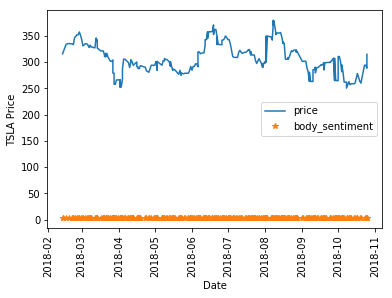

In [133]:
#df.plot(x = df['date'], parse_dates=True, y = df['price'])
#df = df.sort_values('date', ascending=True)
#df[['price', 'date']].plot() # this works, but the axes need to be flipped, but won't!
df['price'] = df['price'].astype(float) # This solved the headache!
plt.plot(df['date'], df['price'])
plt.plot(df['date'], df['body_sentiment'], '*')
plt.xticks(rotation='vertical')

#Formatting the plot
plt.xlabel('Date')
plt.ylabel('TSLA Price')
plt.legend()
plt.show()


In [14]:
# Note used
def pageScrape(df):
    """
    count = 1
    for u in df.url:
        res = requests.get(u)
        soup_body = BeautifulSoup(res.text,"lxml")
        article_text = ''
        article = soup_body.find("div", {"class":"post_content"}).findAll('p')
        for element in article:
            article_text += '\n' + ''.join(element.findAll(text = True))    
        #df = df.add
        df = pd.DataFrame(article_text, columns=['body']) # Change this to add a column 
        print('Page = ', count)
        count += 1
        res.close()
        time.sleep(5)
    return df.body """
    #df.to_csv(filename, index=False, encoding='utf-8')    

Ready to delete the below after 10/1

In [ ]:
# This cell is deprecated
url = ("http://articlefeeds.nasdaq.com/nasdaq/symbols?symbol=TSLA")
#url = ("TraderSA.html")
#file = open(url) 
file = urllib.request.urlopen(url)
doc = file.read()
#parser = etree.XMLParser()
parser = etree.XMLParser(ns_clean=True)
output = BytesIO(doc)
tree = etree.parse(output, parser)
result = etree.tostring(tree.getroot(), pretty_print=True, method='html')
soup = BeautifulSoup(result, 'html.parser')
soup.prettify

In [ ]:
# This cell is deprecated
item_list = soup.find_all('item') # Test area
item_list[1]

In [126]:
# This path is dead
item_list = soup.findAll('feedburner:origlink')
#title_list = soup.find_all('title')
#description_list = soup.find_all('description')
#url_list = soup.find_all('item xml:base')
#title_list, description_list, url_list
#title_dict = {}
url_dict = {}
for items in item_list: #.find_all('item'):
    url_dict[items.url] = items #['xml:base']